<a href="https://colab.research.google.com/github/mgorsk1/gargabe-detector-app/blob/baseline/model/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os, glob

import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

Link to the data: https://drive.google.com/open?id=1m6-StcbywxvW95NsyibE7tl3PYRdlfcx

copy data to your google drive and modify `project_dir` below. 

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
project_dir = 'My Drive/projects/ING/Experiment_week/garbage_segmentation/'

data_train_dir = project_dir + 'data/raw/train/'
data_test_dir = project_dir + 'data/raw/test/'
models_dir = project_dir + 'models/'

In [5]:
classes = os.listdir(data_train_dir)
classes

['metal', 'paper', 'glass', 'plastic', 'cardboard']

In [6]:
os.listdir(data_test_dir)

['cardboard', 'glass', 'paper', 'plastic', 'metal']

In [0]:
def stack_images_and_labels(data_dir, do_save=True):
    file_paths = glob.glob(data_dir + '*/*')

    df_files = pd.DataFrame(file_paths, columns=['file_path'])
    df_files = df_files.assign(label=df_files['file_path'].str.split('/').apply(lambda x: x[-2]))

    images_list, labels_list = [], []
    for _, row in tqdm(df_files.iterrows(), total=len(df_files)):
        file_path = row[0]
        label = row[1]

        image = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
        image = tf.keras.preprocessing.image.img_to_array(image)

        images_list.append(image)
        labels_list.append(label)

    images = np.stack(images_list)
    labels = np.stack(labels_list)

    if do_save:
        np.save(data_dir.replace('raw', 'processed') + 'images.npy', images)
        np.save(data_dir.replace('raw', 'processed') + 'labels.npy', labels)

    return images, labels

In [0]:
images_train, labels_train = stack_images_and_labels(data_train_dir)

In [9]:
images_test, labels_test = stack_images_and_labels(data_test_dir)

In [81]:
images_train = np.load(data_train_dir.replace('raw', 'processed') + 'images.npy')
labels_train = np.load(data_train_dir.replace('raw', 'processed') + 'labels.npy')
images_test = np.load(data_test_dir.replace('raw', 'processed') + 'images.npy')
labels_test = np.load(data_test_dir.replace('raw', 'processed') + 'labels.npy')

images_train.shape, labels_train.shape, images_test.shape, labels_test.shape

((3989, 224, 224, 3), (3989,), (186, 224, 224, 3), (186,))

In [0]:
def plot_images(images, labels):
    indices = np.random.choice(range(len(images)), size=10)
    fig, axs = plt.subplots(2, 5, figsize=(15, 5))
    axs = [j for i in axs for j in i]
    for i, index in enumerate(indices):
        axs[i].imshow(images[index].astype(int)) 
        axs[i].set_title(labels[index])

    plt.tight_layout()

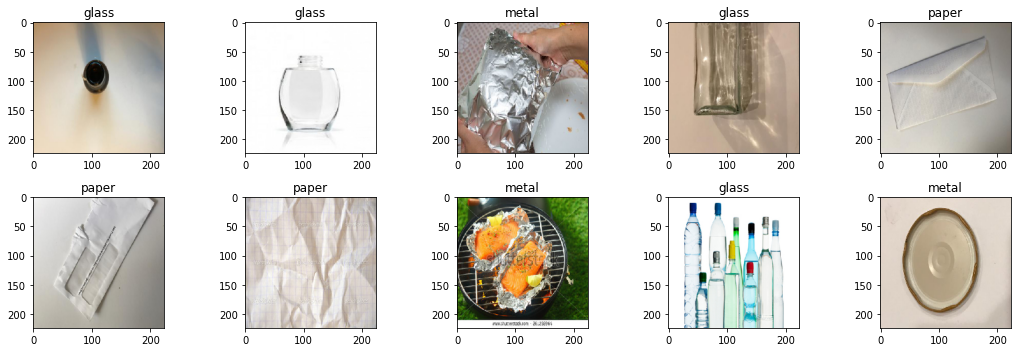

In [13]:
plot_images(images_train, labels_train)

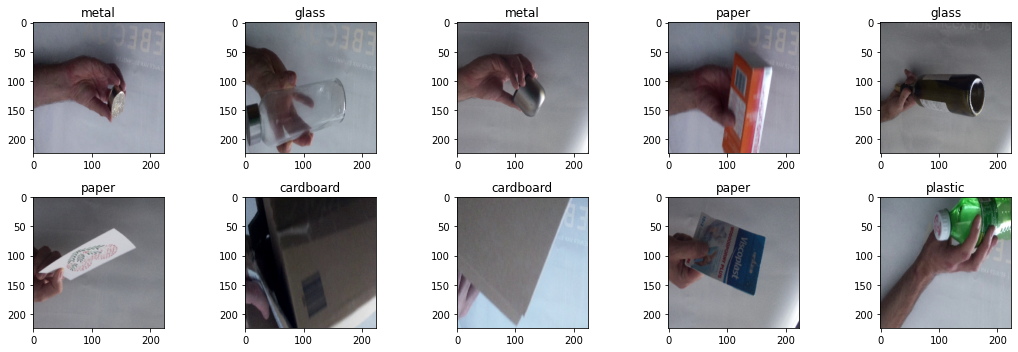

In [14]:
plot_images(images_test, labels_test)

In [0]:
def compute_image_embedding(images, model, preprocess_input, input_shape, data_dir, do_save=True):
    images_preped = preprocess_input(np.copy(images))
    images_embedding = model.predict(images_preped, batch_size=32, verbose=1)
    if do_save:
        np.save(data_dir.replace('raw', 'processed') + 'images_embedding.npy', images_embedding)
    return images_embedding

In [35]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input
input_shape = (224, 224, 3)

model_base = tf.keras.applications.resnet50.ResNet50(include_top=False, input_shape=input_shape)

94773248/94765736 [==============================] - 1s 0us/step


In [0]:
images_embedding_train = compute_image_embedding(images_train, model_base, preprocess_input, input_shape, data_train_dir)

125/125 [==============================] - 26s 206ms/step


In [17]:
images_embedding_test = compute_image_embedding(images_test, model_base, preprocess_input, input_shape, data_test_dir)

6/6 [==============================] - 0s 82ms/step


In [23]:
images_embedding_train = np.load(data_train_dir.replace('raw', 'processed') + 'images_embedding.npy')
labels_train = np.load(data_train_dir.replace('raw', 'processed') + 'labels.npy')

images_embedding_train.shape, labels_train.shape

((3989, 7, 7, 2048), (3989,))

In [24]:
images_embedding_test = np.load(data_test_dir.replace('raw', 'processed') + 'images_embedding.npy')
labels_test = np.load(data_test_dir.replace('raw', 'processed') + 'labels.npy')

images_embedding_test.shape, labels_test.shape

((186, 7, 7, 2048), (186,))

In [25]:
images_embedding_train.mean(), images_embedding_train.std()

(0.4421334, 1.671736)

In [26]:
images_embedding_test.mean(), images_embedding_test.std()

(0.5286876, 1.8500848)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [28]:
images_embedding_train, images_embedding_val, labels_train, labels_val = train_test_split(images_embedding_train, labels_train, random_state=1)
images_embedding_train.shape

(2991, 7, 7, 2048)

In [0]:
def to_categorical(labels, label_to_index):
    labels_int = pd.Series(labels).map(label_to_index)
    return tf.keras.utils.to_categorical(labels_int, num_classes=len(label_to_index)) 

In [0]:
label_to_index = dict(zip(classes, range(len(classes))))

labels_train_c = to_categorical(labels_train, label_to_index)
labels_val_c = to_categorical(labels_val, label_to_index)
labels_test_c = to_categorical(labels_test, label_to_index)

In [31]:
images_embedding_train.shape

(2991, 7, 7, 2048)

In [0]:
def make_model(model_base=None, embeddings_shape=None):
    if model_base:
        embeddings = model_base.output
        inputs = model_base.input

    elif embeddings_shape:
        embeddings = tf.keras.Input(shape=embeddings_shape)
        inputs = embeddings
    
    x = tf.keras.layers.BatchNormalization(input_shape=(7, 7, 2048))(embeddings)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(100, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    output = tf.keras.layers.Dense(len(classes), activation='softmax')(x)

    return tf.keras.models.Model(inputs=inputs, outputs=output)

In [57]:
model_top = make_model(embeddings_shape=(7, 7, 2048))
model_top.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 7, 7, 2048)]      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 2048)        8192      
_________________________________________________________________
flatten_8 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_24 (Dense)             (None, 1000)              100353000 
_________________________________________________________________
dropout_16 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               100100    
_________________________________________________________________
dropout_17 (Dropout)         (None, 100)               0   

In [0]:
model_top.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False)
)

In [59]:
new_learning_rate = 0.001

print('current_learning_rate', tf.keras.backend.get_value(model_top.optimizer.lr))
tf.keras.backend.set_value(model_top.optimizer.lr, new_learning_rate)
print('current_learning_rate', tf.keras.backend.get_value(model_top.optimizer.lr))

current_learning_rate 0.001
current_learning_rate 0.001


In [60]:
model_top.fit(
    images_embedding_train, 
    labels_train_c,
    validation_data=(images_embedding_val, labels_val_c),
    validation_freq=10,
    batch_size=32, 
    epochs=2
)

Epoch 1/2
94/94 [==============================] - 5s 53ms/step - loss: 3.0344
Epoch 2/2
94/94 [==============================] - 5s 53ms/step - loss: 0.7565


In [0]:
model_top.save(models_dir + 'model_top0.h5')

In [0]:
model_top = tf.keras.models.load_model(models_dir + 'model_top0.h5')

In [61]:
prediction_train = model_top.predict(images_embedding_train)

print(
    classification_report(
        labels_train_c.argmax(axis=1), 
        prediction_train.argmax(axis=1), 
        target_names=classes
    )
)

              precision    recall  f1-score   support

       metal       0.92      0.98      0.95       630
       paper       0.94      0.97      0.95       629
       glass       0.93      0.95      0.94       730
     plastic       0.97      0.87      0.92       698
   cardboard       0.98      0.94      0.96       304

    accuracy                           0.94      2991
   macro avg       0.95      0.94      0.94      2991
weighted avg       0.94      0.94      0.94      2991



In [62]:
prediction_val = model_top.predict(images_embedding_val)

print(
    classification_report(
        labels_val_c.argmax(axis=1), 
        prediction_val.argmax(axis=1), 
        target_names=classes
    )
)

              precision    recall  f1-score   support

       metal       0.88      0.87      0.87       216
       paper       0.91      0.91      0.91       224
       glass       0.82      0.86      0.84       223
     plastic       0.83      0.81      0.82       236
   cardboard       0.92      0.93      0.92        99

    accuracy                           0.87       998
   macro avg       0.87      0.87      0.87       998
weighted avg       0.87      0.87      0.87       998



In [63]:
prediction_test = model_top.predict(images_embedding_test)

print(
    classification_report(
        labels_test_c.argmax(axis=1), 
        prediction_test.argmax(axis=1), 
        target_names=classes
    )
)

              precision    recall  f1-score   support

       metal       0.86      0.24      0.38        50
       paper       0.50      0.92      0.65        36
       glass       0.36      0.22      0.27        45
     plastic       0.25      0.52      0.34        25
   cardboard       0.88      0.77      0.82        30

    accuracy                           0.49       186
   macro avg       0.57      0.53      0.49       186
weighted avg       0.59      0.49      0.47       186



# assemble model

In [0]:
def assemble_model(model_top, model_base):
    model = make_model(model_base)

    for l in range(1, len(model_top.layers)):
        weights = model_top.layers[-l].get_weights()
        model.layers[-l].set_weights(weights)

    return model

In [0]:
model = assemble_model(model_top, model_base)

In [88]:
images_test_preped = tf.keras.applications.resnet50.preprocess_input(np.copy(images_test))

prediction_test = model.predict(images_test_preped)

print(
    classification_report(
        labels_test_c.argmax(axis=1), 
        prediction_test.argmax(axis=1), 
        target_names=classes
    )
)

              precision    recall  f1-score   support

       metal       0.86      0.24      0.38        50
       paper       0.50      0.92      0.65        36
       glass       0.36      0.22      0.27        45
     plastic       0.25      0.52      0.34        25
   cardboard       0.88      0.77      0.82        30

    accuracy                           0.49       186
   macro avg       0.57      0.53      0.49       186
weighted avg       0.59      0.49      0.47       186

